# EAF Coffea-Casa Benchmark Example 8 - Gateway and HTCondor

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program plots the transverse mass of MET and a third lepton, 
# where the third lepton is associated with a lepton pair that has the same flavor, opposite charge, 
# and closest mass to 91.2.

import math

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "MET and Third Lepton")
        muon_axis = hist.Bin("massT", "Transverse Mass", 50, 15, 250)
        
        self._accumulator = processor.dict_accumulator({
            'massT': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        # Keep track of muons and electrons by tagging them 0/1.
        muons = ak.with_field(events.Muon, 0, 'flavor')
        electrons = ak.with_field(events.Electron, 1, 'flavor')
        MET = events.MET
        
        output['cutflow']['all events'] += ak.size(events.MET, axis=0)
        
        # A few reasonable muon and electron selection cuts
        muons = muons[(muons.pt > 10) & (np.abs(muons.eta) < 2.4)]
        electrons = electrons[(electrons.pt > 10) & (np.abs(electrons.eta) < 2.5)]
        
        output['cutflow']['all muons'] += ak.sum(ak.count(muons, axis=1))
        output['cutflow']['all electrons'] += ak.sum(ak.count(electrons, axis=1))

        # Stack muons and electrons into a single array.
        leptons = ak.with_name(ak.concatenate([muons, electrons], axis=1), 'PtEtaPhiMCandidate')
        
        # Filter out events with less than 3 leptons.
        trileptons = leptons[ak.num(leptons, axis=1) >= 3]
        output['cutflow']['trileptons'] += ak.sum(ak.num(trileptons, axis=1))
        
        # Generate the indices of every pair; indices because we'll be removing these elements later.
        lepton_pairs = ak.argcombinations(trileptons, 2, fields=['i0', 'i1'])
        
        # Select pairs that are SFOS.
        SFOS_pairs = lepton_pairs[(trileptons[lepton_pairs['i0']].flavor == trileptons[lepton_pairs['i1']].flavor) & (trileptons[lepton_pairs['i0']].charge != trileptons[lepton_pairs['i1']].charge)]
        
        # Find the pair with mass closest to Z.
        closest_pairs = SFOS_pairs[ak.local_index(SFOS_pairs) == ak.argmin(np.abs((trileptons[SFOS_pairs['i0']] + trileptons[SFOS_pairs['i1']]).mass - 91.2), axis=1)]
        
        # Make trileptons and closest_pairs have same shape. First, fill nones with empty arrays.
        #Then filter out events that don't meet the pair requirement.
        closest_pairs = ak.fill_none(closest_pairs, [], axis=0)
        closest_pairs = closest_pairs[ak.num(closest_pairs) > 0]
        trileptons = trileptons[ak.num(closest_pairs) > 0]
        MET = MET[ak.num(closest_pairs) > 0]
        
        # Remove elements of the closest pairs from leptons, because we want the pt of the third lepton.
        trileptons_no_pair = trileptons[(ak.local_index(trileptons) != ak.flatten(closest_pairs.i0)) & (ak.local_index(trileptons) != ak.flatten(closest_pairs.i1))]
        
        # Find the highest-pt lepton out of the ones that remain.
        leading_lepton = trileptons_no_pair[ak.argmax(trileptons_no_pair.pt, axis=1)]
        output['cutflow']['number of final leading leptons'] += ak.sum(ak.num(trileptons_no_pair, axis=1))
        
        # Cross MET with the leading lepton.
        met_plus_lep = ak.cartesian({'i0': MET, 'i1': leading_lepton})
        
        # Do some math to get what we want.
        dphi_met_lep = (met_plus_lep.i0.phi - met_plus_lep.i1.phi + math.pi) % (2*math.pi) - math.pi
        mt_lep = np.sqrt(2.0*met_plus_lep.i0.pt*met_plus_lep.i1.pt*(1.0-np.cos(dphi_met_lep)))
        
        output['massT'].fill(dataset=dataset, massT=ak.flatten(mt_lep))
        
        return output

    def postprocess(self, accumulator):
        return accumulator

# Connecting to the gateway
The code in the following cell imports the LPCGateway and connects to a cluster of HTCondor workers.
* gateway.new_cluster() starts a new cluster
* cluster.scale(N) specifies the number of workers in the cluster, here there are N workes in the cluster
* cluster.get_client() obtains the client that will connect your cluster to the scheduler, this is how the HTCondor workers are assigned to your tasks on the grid

In [3]:
from lpcdaskgateway import LPCGateway

gateway = LPCGateway()
cluster = gateway.new_cluster()
cluster

# Scale my cluster to 5 HTCondor workers
cluster.scale(10)

# Obtain a client for connecting to your cluster scheduler
# Your cluster should be ready to take requests
client = cluster.get_client()
client

INFO:lpcdaskgateway.LPCGateway: Creating LPCGatewayCluster 
INFO:lpcdaskgateway.GatewayCluster: Scaling: 10 HTCondor workers
INFO:lpcdaskgateway.GatewayCluster: Sandbox: /uscmst1b_scratch/lpc1/3DayLifetime/elisec/dask-gateway.16aa67fdd1e34faab8972726a2894b46
INFO:lpcdaskgateway.GatewayCluster: Success! submitted HTCondor jobs to lpcschedd2.fnal.gov with  ClusterId 37113559


Client Scheduler: gateway://172.30.227.32:80/dask-gateway.16aa67fdd1e34faab8972726a2894b46 Dashboard: https://dask-gateway.fnal.gov/clusters/dask-gateway.16aa67fdd1e34faab8972726a2894b46/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Warning: running on HTCondor could take some time
The scheduler has to have available workers to connect to your cluster, this is what takes some time. After they connect, it should be much faster.

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

INFO:numexpr.utils:Note: NumExpr detected 22 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
[                                        ] | 0% Completed |  0.1s

/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


{'bytesread': 9982563224,
 'columns': ['Electron_dxy',
  'Muon_dxy',
  'Muon_dxyErr',
  'nMuon',
  'Electron_pfId',
  'Electron_dz',
  'MET_sumet',
  'Electron_jetIdx',
  'Electron_mass',
  'MET_significance',
  'Electron_dzErr',
  'Electron_cutBasedId',
  'MET_CovXY',
  'Muon_softId',
  'MET_CovYY',
  'Electron_dxyErr',
  'Muon_dz',
  'Electron_pfRelIso03_all',
  'Muon_phi',
  'Muon_pfRelIso03_all',
  'MET_phi',
  'Muon_genPartIdx',
  'Muon_pt',
  'Electron_genPartIdx',
  'Muon_charge',
  'Muon_eta',
  'nJet',
  'Muon_jetIdx',
  'Electron_charge',
  'Muon_pfRelIso04_all',
  'MET_pt',
  'MET_CovXX',
  'Muon_tightId',
  'Electron_phi',
  'Muon_mass',
  'Electron_pt',
  'Muon_dzErr',
  'Electron_eta',
  'nElectron'],
 'entries': 53446198,
 'processtime': 3388.0045602321625,
 'chunks': 534}

<AxesSubplot:xlabel='Transverse Mass', ylabel='Counts'>

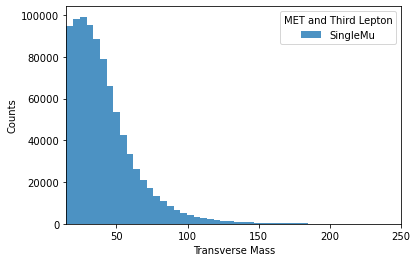

In [5]:
hist.plot1d(output['massT'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all muons 991421725
all electrons 87391040
trileptons 5043516
number of final leading leptons 1227755


### Do not forget to shutdown your cluster
cluster.shutdown() does that gracefully

In [7]:
cluster.shutdown()

INFO:lpcdaskgateway.GatewayCluster: Shutting down HTCondor worker jobs



Couldn't find/remove all jobs in cluster 37113559
distributed.client - WARNING - Exception raised while closing clients
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/lpcdaskgateway/cluster.py", line 178, in destroy_all_batch_clusters
    result = subprocess.check_output(['sh','-c',cmd], cwd=htc_cluster['Iwd'])
  File "/opt/conda/lib/python3.8/subprocess.py", line 411, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/opt/conda/lib/python3.8/subprocess.py", line 512, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command '['sh', '-c', 'condor_rm 37113559 -name lpcschedd2.fnal.gov']' returned non-zero exit status 1.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/dask_gateway/client.py", line 983, in _stop_internal
    await self._stop_task
  File "/opt/conda/lib/

ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
ERROR:asyncio:Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/op